In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline



/home/nandu/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
data=pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])
data.drop(['timestamp'], axis=1,inplace=True)

In [3]:
data.describe()

,Rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [4]:
data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [5]:
data.shape

(7824482, 3)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
#Taking subset of the dataset
data=data.iloc[:1048576,0:]

In [8]:
print('Minimum rating is: %d' %(data.Rating.min()))
print('Maximum rating is: %d' %(data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [9]:
data.isnull().values.any()

False

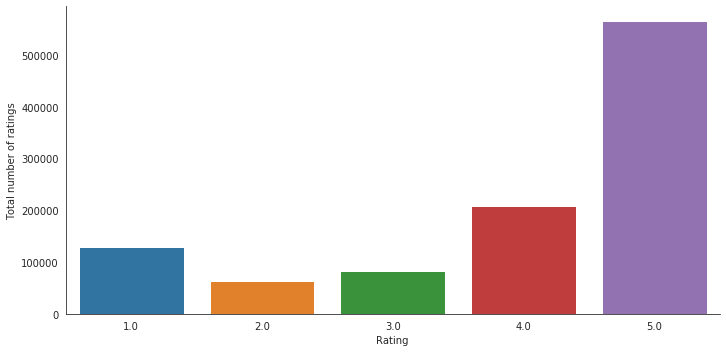

In [10]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [11]:
no_of_rated_products_per_user = data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

# Collaborative filtering (Item-Item recommendation)

In [12]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [13]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [14]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [15]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [16]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [17]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [18]:
test_pred

[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

In [19]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

# Model-based collaborative filtering system

In [20]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
ratings_matrix.shape

(9832, 76)

In [22]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X.shape

(76, 9832)

In [24]:
X1 = X

In [25]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [26]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [27]:
X.index[75]

'B00000K135'

In [28]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [29]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [30]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['3744295508',
 '8862935293',
 '9573212919',
 '9625993428',
 '9888002198',
 '9983891212',
 '9984984354',
 'B00000IGBF',
 'B00000J0D8',
 'B00000J434',
 'B00000J4FS']